##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Original notebook obtained from https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker


# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [ ]:
# !pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 18.9 MB/s eta 0:00:00


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [1]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Visualization utilities

In [33]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    x_avg, y_avg = 0, 0
    for landmark in hand_landmarks_proto.landmark:
      x_avg += landmark.x
      y_avg += landmark.y
    x_avg /= len(hand_landmarks_proto.landmark)
    y_avg /= len(hand_landmarks_proto.landmark)

    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())
    
    # Convert x_avg and y_avg from percentages to pixel values
    height, width, _ = annotated_image.shape
    x_avg_pixel = int(x_avg * width)
    y_avg_pixel = int(y_avg * height)
    print("Putting circle at ", x_avg_pixel, y_avg_pixel)
    # Draw a dot at the x_avg and y_avg locations
    cv2.circle(annotated_image, (x_avg_pixel, y_avg_pixel), radius=10, color=(0, 0, 255), thickness=-1)


    # Get the top left corner of the detected hand's bounding box.
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

In [34]:
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

def imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
img = cv2.imread("image.jpg")
# imshow(img)

## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


Putting circle at  99 685
Putting circle at  410 382


I0000 00:00:1741811411.698714    7446 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741811411.795388    8070 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2
W0000 00:00:1741811411.816944    8074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741811411.825801    8078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


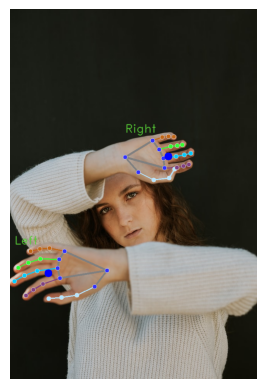

In [35]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))